## Data Preprocessing and Helper Functions

This section defines helper functions used to clean, standardise, and integrate transaction, geographic, and demographic datasets for the Bristol house price analysis (2015–2024).

Postcode formatting is standardised using `clean_postcode_unit()`, and unit postcodes are aggregated to postcode sector level with `postcode_sector_from_unit()`, providing a stable spatial scale for analysis. Geographic identifiers are harmonised across datasets using `standardise_lad_cols()`, ensuring consistent Local Authority and LSOA codes despite differences in release years.

Demographic data are aggregated using `add_total_sex_age_cols()`, which combines age-specific male and female counts into total population indicators used for modelling. The utility function `find_col()` supports flexible column matching across datasets with inconsistent naming.

Together, these functions establish a reproducible preprocessing pipeline that ensures data consistency prior to exploratory analysis and modelling.


In [1]:
# ============================================================
# BRISTOL HOUSE PRICE PROJECT — POSTCODE SECTOR (2015–2024)
# Uses:
#   /content/bristol_master_transactions.csv
#   /content/bs.csv
#   /content/Merged_Sapelsoa.csv
#   /content/ONSPD.csv
# ============================================================

# =========================
# 1) Imports + helper functions
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path

def clean_postcode_unit(pc):
    """Standard UK postcode unit: uppercase + single space before last 3 chars."""
    if pd.isna(pc):
        return np.nan
    pc = str(pc).strip().upper().replace(" ", "")
    if len(pc) < 5:
        return np.nan
    return pc[:-3] + " " + pc[-3:]

def postcode_sector_from_unit(pc_unit):
    """
    Convert unit postcode -> sector postcode.
    Example:
      BS1 1AA -> BS1 1
      BS10 5AA -> BS10 5
    """
    pc_unit = clean_postcode_unit(pc_unit)
    if pd.isna(pc_unit):
        return np.nan
    try:
        outward, inward = pc_unit.split(" ")
        return outward + " " + inward[0]
    except Exception:
        return np.nan

def standardise_lad_cols(df):
    """Make LAD 2021 vs LAD 2023 consistent + standardise LSOA col names."""
    rename_map = {}
    if "LAD 2021 Code" in df.columns: rename_map["LAD 2021 Code"] = "LAD_Code"
    if "LAD 2021 Name" in df.columns: rename_map["LAD 2021 Name"] = "LAD_Name"
    if "LAD 2023 Code" in df.columns: rename_map["LAD 2023 Code"] = "LAD_Code"
    if "LAD 2023 Name" in df.columns: rename_map["LAD 2023 Name"] = "LAD_Name"
    if "LSOA 2021 Code" in df.columns: rename_map["LSOA 2021 Code"] = "LSOA_2021_Code"
    if "LSOA 2021 Name" in df.columns: rename_map["LSOA 2021 Name"] = "LSOA_2021_Name"
    df = df.rename(columns=rename_map)
    for col in ["LAD_Code", "LAD_Name", "LSOA_2021_Code", "LSOA_2021_Name"]:
        if col not in df.columns:
            df[col] = pd.NA
    return df

def add_total_sex_age_cols(ons):
    """
    Merge Female (F0..F90) and Male (M0..M90) into Total (T0..T90)
    + totals Female_Total, Male_Total, Pop_Total_FM.
    (We will NOT use T* in final merge; totals only.)
    """
    f_cols = [c for c in ons.columns if re.fullmatch(r"F\d+", str(c))]
    m_cols = [c for c in ons.columns if re.fullmatch(r"M\d+", str(c))]
    f_ages = sorted([int(c[1:]) for c in f_cols])
    m_ages = sorted([int(c[1:]) for c in m_cols])
    common_ages = sorted(set(f_ages).intersection(set(m_ages)))

    if common_ages:
        ons["Female_Total"] = ons[[f"F{a}" for a in common_ages]].apply(pd.to_numeric, errors="coerce").sum(axis=1)
        ons["Male_Total"]   = ons[[f"M{a}" for a in common_ages]].apply(pd.to_numeric, errors="coerce").sum(axis=1)
        ons["Pop_Total_FM"] = ons["Female_Total"] + ons["Male_Total"]
    else:
        ons["Female_Total"] = pd.NA
        ons["Male_Total"] = pd.NA
        ons["Pop_Total_FM"] = pd.NA

    return ons

def find_col(cols, candidates):
    """Find a column in cols matching one of candidates (case-insensitive)."""
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

## Data Loading and Validation

This step loads the four primary datasets used in the analysis: property transactions, Code-Point geographic data, ONS demographic data, and the ONS Postcode Directory (ONSPD). File paths are explicitly defined and validated to ensure that all required inputs are available before processing.

The transaction and ONS datasets are read directly using standard CSV loading. As the Code-Point Open file does not include a header row, column names are manually assigned to ensure correct interpretation of postcode units and geographic coordinates.

Basic shape checks are printed for each dataset to confirm successful loading and provide an initial overview of data volume prior to cleaning and integration.

In [2]:
# =========================
# 2) Load datasets
# =========================
transactions_path = "/content/bristol_master_transactions.csv"
codepoint_path    = "/content/bs.csv"
ons_path          = "/content/Merged_Sapelsoa.csv"
onspd_path        = "/content/ONSPD.csv"

for p in [transactions_path, codepoint_path, ons_path, onspd_path]:
    if not Path(p).exists():
        raise FileNotFoundError(f"Missing file at: {p}")

tx = pd.read_csv(transactions_path)

# bs.csv typically has NO header row; assign names
bs_cols = [
    "postcode_unit", "pqi", "easting", "northing",
    "country_code", "nhs_regional_ha", "nhs_ha",
    "admin_county", "admin_district", "admin_ward"
]
bs = pd.read_csv(codepoint_path, header=None, names=bs_cols)

ons = pd.read_csv(ons_path)

print("Transactions:", tx.shape)
print("Code-Point:", bs.shape)
print("ONS:", ons.shape)


Transactions: (127755, 16)
Code-Point: (27393, 10)
ONS: (2948, 189)


## Transaction Data Cleaning and Preparation

This step prepares the property transaction dataset for analysis at the postcode sector and yearly level. Raw postcode values are first standardised and converted from unit postcodes to postcode sectors, enabling spatial aggregation at a consistent geographic scale.

Transaction dates are parsed to extract the year of sale, and records with missing postcode sectors, prices, or dates are removed. Transactions are further filtered to retain valid sales only (positive prices) within the study period from 2015 to 2024.

Finally, the dataset is restricted to Bristol postcode sectors (those beginning with “BS”), ensuring geographic relevance. The resulting cleaned dataset contains valid transaction records indexed by postcode sector and year, forming the basis for subsequent aggregation and modelling.


In [3]:
# =========================
# 3) Clean / prepare transactions (POSTCODE SECTOR + year)
# =========================
tx["postcode_unit"] = tx["postcode"].apply(clean_postcode_unit)
tx["postcode_sector"] = tx["postcode_unit"].apply(postcode_sector_from_unit)

tx["date_of_transfer"] = pd.to_datetime(tx["date_of_transfer"], errors="coerce")
tx["year"] = tx["date_of_transfer"].dt.year

tx = tx.dropna(subset=["postcode_sector", "price", "year"])
tx = tx[(tx["price"] > 0) & (tx["year"].between(2015, 2024))]

# Keep Bristol sectors only (BS*)
tx = tx[tx["postcode_sector"].astype(str).str.startswith("BS")].copy()

print("Transactions after cleaning (sector):", tx.shape)
print(tx[["postcode_sector","year","price"]].head())

Transactions after cleaning (sector): (122484, 19)
  postcode_sector  year   price
0           BS1 6  2015  257500
1          BS10 5  2015  427500
2           BS4 1  2015  140000
3          BS10 5  2015  280000
4           BS3 3  2015  185000


## Code-Point Geographic Data Preparation

This step processes Ordnance Survey Code-Point Open data to derive geographic centroids at the postcode sector level. Unit postcodes are first standardised and converted to postcode sectors to ensure consistency with the transaction dataset.

Easting and northing coordinates are converted to numeric format, and records with missing geographic information are removed. Mean easting and northing values are then calculated for each postcode sector, producing a single centroid representation per sector.

The dataset is restricted to Bristol postcode sectors (prefixed with “BS”), resulting in a clean sector-level geographic reference used for spatial analysis and modelling.


In [4]:
# =========================
# 4) Clean / prepare Code-Point (UNIT -> SECTOR centroid)
# =========================
bs["postcode_unit"] = bs["postcode_unit"].apply(clean_postcode_unit)
bs["postcode_sector"] = bs["postcode_unit"].apply(postcode_sector_from_unit)

# Numeric conversion safety
bs["easting"] = pd.to_numeric(bs["easting"], errors="coerce")
bs["northing"] = pd.to_numeric(bs["northing"], errors="coerce")

bs_geo = (
    bs.dropna(subset=["postcode_sector", "easting", "northing"])
      .groupby("postcode_sector", as_index=False)
      .agg(easting=("easting", "mean"),
           northing=("northing", "mean"))
)

# Keep Bristol sectors
bs_geo = bs_geo[bs_geo["postcode_sector"].astype(str).str.startswith("BS")].copy()

print("Code-Point sector geography:", bs_geo.shape)
print(bs_geo.head())

Code-Point sector geography: (166, 3)
  postcode_sector        easting       northing
0           BS1 1  358827.841270  172961.984127
1           BS1 2  358846.676471  173215.882353
2           BS1 3  359164.529412  173519.899160
3           BS1 4  358711.183673  172685.346939
4           BS1 5  358269.202614  172825.013072


## ONS Demographic Data Preparation

This step prepares the ONS SAPELSOA demographic dataset for integration with the housing data. Local Authority District (LAD) and LSOA identifiers are first standardised to ensure consistent geographic referencing across datasets.

Age-specific male and female population columns are then aggregated into total female, total male, and combined population measures using `add_total_sex_age_cols()`. These totals provide concise demographic indicators suitable for postcode-sector-level analysis.

Finally, the year variable is validated and converted to numeric format to ensure compatibility with temporal aggregation and modelling. The resulting dataset contains clean, year-specific population totals indexed by LSOA.


In [5]:
# =========================
# 5) Prepare ONS SAPELSOA (totals only)
# =========================
ons = standardise_lad_cols(ons)
ons = add_total_sex_age_cols(ons)

# Ensure Year numeric
if "Year" in ons.columns:
    ons["Year"] = pd.to_numeric(ons["Year"], errors="coerce")
elif "year" in ons.columns:
    ons["Year"] = pd.to_numeric(ons["year"], errors="coerce")
else:
    raise ValueError("ONS file must have a Year column (Year or year).")

print("ONS after totals:", ons.shape)
print(ons[["LSOA_2021_Code","Year","Female_Total","Male_Total","Pop_Total_FM"]].head())

ONS after totals: (2948, 192)
  LSOA_2021_Code  Year  Female_Total  Male_Total  Pop_Total_FM
0      E01014485  2015           994         911          1905
1      E01014486  2015          1261        1303          2564
2      E01014487  2015           976        1020          1996
3      E01014488  2015           998        1017          2015
4      E01014489  2015          1240        1364          2604


## Construction of Target Variables

This step constructs the target variables used for modelling by aggregating transaction data at the postcode sector and yearly level. For each postcode sector–year combination, the mean house price is calculated as the primary prediction target.

In addition, median house price and transaction count (`n_sales`) are computed to provide robust price summaries and a measure of market activity. These aggregated indicators form the core response and contextual variables for subsequent modelling and evaluation.


In [6]:
# =========================
# 6) Build target variable: average price by POSTCODE SECTOR and year
# =========================
price_by_sector_year = (
    tx.groupby(["postcode_sector", "year"], as_index=False)
      .agg(avg_price=("price", "mean"),
           median_price=("price", "median"),
           n_sales=("price", "size"))
)

print("Price table (sector×year):", price_by_sector_year.shape)
print(price_by_sector_year.head())

Price table (sector×year): (1144, 5)
  postcode_sector  year     avg_price  median_price  n_sales
0           BS1 1  2015  3.288500e+05      128000.0       27
1           BS1 1  2016  4.569979e+05      132750.0       24
2           BS1 1  2017  4.977970e+05      168550.0       13
3           BS1 1  2018  3.299123e+05      187000.0       81
4           BS1 1  2019  1.652299e+06      207500.0       28


## Adding Geography and Linking Postcode Sectors to LSOA (ONSPD)

This step enriches the sector–year price table by merging postcode sector centroids (mean easting and northing) derived from Code-Point Open, enabling spatial analysis and mapping.

Next, the ONS Postcode Directory (ONSPD) is used to link postcodes to LSOA codes for integrating demographic data. The file is read robustly to handle formatting issues, and the relevant postcode and LSOA columns are detected automatically to support different ONSPD schemas. Unit postcodes are cleaned and converted to postcode sectors, then filtered to Bristol (“BS”) sectors only.

Because a postcode sector can map to multiple unit postcodes (and potentially multiple LSOAs), the mapping is reduced to a single representative LSOA per sector by selecting the dominant (most frequent) LSOA code. The resulting sector-level lookup table provides a consistent join key between postcode sectors and the ONS demographic dataset.


In [7]:
# =========================
# 7) Add geography (sector centroid)
# =========================
price_geo = price_by_sector_year.merge(bs_geo, on="postcode_sector", how="left")
print("After adding geography:", price_geo.shape)
print(price_geo.head())


# =========================
# 8) ONSPD lookup: UNIT -> LSOA, then reduce to SECTOR -> dominant LSOA
# =========================
# Robust read
try:
    lookup_raw = pd.read_csv(onspd_path)
except Exception as e:
    print("Standard read_csv failed:", repr(e))
    print("Trying tolerant read (engine='python', on_bad_lines='skip')...")
    lookup_raw = pd.read_csv(onspd_path, engine="python", on_bad_lines="skip", encoding_errors="replace")

postcode_col = find_col(lookup_raw.columns, ["pcds", "pcd", "postcode", "PCDS", "PCD"])
lsoa_col = find_col(lookup_raw.columns, ["lsoa21", "lsoa21cd", "LSOA21CD", "lsoa_2021"])
if lsoa_col is None:
    lsoa_col = find_col(lookup_raw.columns, ["lsoa11", "lsoa11cd", "LSOA11CD", "lsoa_2011"])

if postcode_col is None or lsoa_col is None:
    raise ValueError(
        f"Could not identify postcode + LSOA columns.\n"
        f"postcode_col={postcode_col}, lsoa_col={lsoa_col}\n"
        f"Columns (first 60): {lookup_raw.columns.tolist()[:60]}"
    )

lookup = lookup_raw[[postcode_col, lsoa_col]].copy()
lookup["postcode_unit"] = lookup[postcode_col].apply(clean_postcode_unit)
lookup["postcode_sector"] = lookup["postcode_unit"].apply(postcode_sector_from_unit)
lookup["LSOA_2021_Code"] = lookup[lsoa_col].astype(str)

lookup = lookup.dropna(subset=["postcode_sector","LSOA_2021_Code"])
lookup = lookup[["postcode_sector","LSOA_2021_Code"]].drop_duplicates()

# Bristol sectors only
lookup = lookup[lookup["postcode_sector"].astype(str).str.startswith("BS")].copy()

# Reduce many-to-one: sector -> dominant LSOA (mode)
lookup_sector = (
    lookup.groupby("postcode_sector")["LSOA_2021_Code"]
          .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
          .reset_index()
)

print("Lookup sector shape:", lookup_sector.shape)
print(lookup_sector.head())

After adding geography: (1144, 7)
  postcode_sector  year     avg_price  median_price  n_sales       easting  \
0           BS1 1  2015  3.288500e+05      128000.0       27  358827.84127   
1           BS1 1  2016  4.569979e+05      132750.0       24  358827.84127   
2           BS1 1  2017  4.977970e+05      168550.0       13  358827.84127   
3           BS1 1  2018  3.299123e+05      187000.0       81  358827.84127   
4           BS1 1  2019  1.652299e+06      207500.0       28  358827.84127   

        northing  
0  172961.984127  
1  172961.984127  
2  172961.984127  
3  172961.984127  
4  172961.984127  


/tmp/ipython-input-751529031.py:14: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup_raw = pd.read_csv(onspd_path)


Lookup sector shape: (206, 2)
  postcode_sector LSOA_2021_Code
0           BS0 1      E01035215
1           BS1 1      E01014654
2           BS1 2      E01033342
3           BS1 3      E01014489
4           BS1 4      E01033353


## Merging Price Data with LSOA Identifiers

This step merges the sector–year price and geographic dataset with the postcode sector–to–LSOA lookup table derived from the ONS Postcode Directory. The merge assigns a single representative LSOA code to each postcode sector, enabling linkage with demographic data reported at LSOA level.

A left join is used to retain all postcode sector–year price observations, even where LSOA information may be missing. The resulting dataset provides a unified structure combining prices, spatial coordinates, and LSOA identifiers for subsequent demographic integration and modelling.


In [8]:
# =========================
# 9) Merge: price_geo (sector×year) + lookup_sector (sector -> LSOA)
# =========================
price_geo_lsoa = price_geo.merge(lookup_sector, on="postcode_sector", how="left")
print("After adding LSOA:", price_geo_lsoa.shape)
print(price_geo_lsoa.head())

After adding LSOA: (1144, 8)
  postcode_sector  year     avg_price  median_price  n_sales       easting  \
0           BS1 1  2015  3.288500e+05      128000.0       27  358827.84127   
1           BS1 1  2016  4.569979e+05      132750.0       24  358827.84127   
2           BS1 1  2017  4.977970e+05      168550.0       13  358827.84127   
3           BS1 1  2018  3.299123e+05      187000.0       81  358827.84127   
4           BS1 1  2019  1.652299e+06      207500.0       28  358827.84127   

        northing LSOA_2021_Code  
0  172961.984127      E01014654  
1  172961.984127      E01014654  
2  172961.984127      E01014654  
3  172961.984127      E01014654  
4  172961.984127      E01014654  


## Integration of Demographic Features

This step merges demographic population totals from the ONS dataset into the sector–year price and geography table. Demographic features are selected at LSOA and year level and linked to postcode sectors using the previously derived LSOA identifier.

A left join is applied to preserve all sector–year price observations, ensuring that housing data remain complete even where demographic information is unavailable for some years or locations. The resulting dataset represents the final analytical table, combining house prices, transaction activity, geographic coordinates, and population indicators for modelling and analysis.


In [9]:
# =========================
# 10) Merge ONS totals (LSOA×Year -> sector×year)
# =========================
ons_features = ["LSOA_2021_Code", "Year", "Female_Total", "Male_Total", "Pop_Total_FM"]
ons_features = [c for c in ons_features if c in ons.columns]
ons_small = ons[ons_features].copy()

final_df = price_geo_lsoa.merge(
    ons_small,
    left_on=["LSOA_2021_Code", "year"],
    right_on=["LSOA_2021_Code", "Year"],
    how="left"
).drop(columns=["Year"], errors="ignore")

print("FINAL merged table:", final_df.shape)
print(final_df.columns.tolist())
print(final_df.head())

FINAL merged table: (1205, 11)
['postcode_sector', 'year', 'avg_price', 'median_price', 'n_sales', 'easting', 'northing', 'LSOA_2021_Code', 'Female_Total', 'Male_Total', 'Pop_Total_FM']
  postcode_sector  year     avg_price  median_price  n_sales       easting  \
0           BS1 1  2015  3.288500e+05      128000.0       27  358827.84127   
1           BS1 1  2016  4.569979e+05      132750.0       24  358827.84127   
2           BS1 1  2017  4.977970e+05      168550.0       13  358827.84127   
3           BS1 1  2018  3.299123e+05      187000.0       81  358827.84127   
4           BS1 1  2019  1.652299e+06      207500.0       28  358827.84127   

        northing LSOA_2021_Code  Female_Total  Male_Total  Pop_Total_FM  
0  172961.984127      E01014654        1263.0      1335.0        2598.0  
1  172961.984127      E01014654        1265.0      1314.0        2579.0  
2  172961.984127      E01014654        1245.0      1283.0        2528.0  
3  172961.984127      E01014654        1233.0    

## Saving the Final Analytical Dataset

This step exports the fully merged and processed dataset to a CSV file at postcode sector level, covering the period from 2015 to 2024. The saved file contains house price metrics, transaction volumes, geographic coordinates, and aggregated demographic indicators.

Exporting the dataset ensures reproducibility and enables reuse for modelling, validation, or external analysis without repeating the full preprocessing pipeline.


In [10]:
# =========================
# 11) Save final dataset (POSTCODE SECTOR)
# =========================
final_out = "/content/Bristol_PostcodeSector_2015_2024.csv"
final_df.to_csv(final_out, index=False, encoding="utf-8")
print("Saved:", final_out)

Saved: /content/Bristol_PostcodeSector_2015_2024.csv


## Exploratory Data Analysis (EDA): Dataset Overview

This section provides an initial exploratory overview of the final analytical dataset at postcode sector level.

First, basic dataset information is displayed using `info()`, summarising the number of observations, variable types, and non-null counts. This helps verify data integrity after the full merging process.

Next, the proportion of missing values is calculated for each variable, allowing identification of features with incomplete coverage that may require careful interpretation or exclusion during modelling.

Summary statistics are then generated for key numerical variables, including house prices, transaction volume, geographic coordinates, and population indicators. These statistics provide insight into central tendency, dispersion, and potential outliers.

Finally, unique counts of postcode sectors and years are reported to confirm spatial and temporal coverage of the dataset and ensure consistency with the intended study period (2015–2024).


In [10]:
# ============================================================
# 1) EDA (Exploratory Data Analysis) — POSTCODE SECTOR VERSION
# Assumes final_df has: postcode_sector
# ============================================================

# 1.1 Basic info
print("\n--- INFO ---")
final_df.info()

# 1.2 Missing values table
print("\n--- MISSING VALUES (%) ---")
missing_pct = (final_df.isna().mean()*100).sort_values(ascending=False)
print(missing_pct)

# 1.3 Summary stats
eda_num_cols = ["avg_price","median_price","n_sales","easting","northing","Female_Total","Male_Total","Pop_Total_FM"]
print("\n--- SUMMARY STATS ---")
print(final_df[eda_num_cols].describe())

# 1.4 Unique counts (SECTORS)
print("\n--- UNIQUE COUNTS ---")
print("Unique postcode sectors:", final_df["postcode_sector"].nunique())
print("Unique years:", final_df["year"].nunique())
print("Years:", sorted(final_df["year"].dropna().unique()))


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   postcode_sector  1205 non-null   object 
 1   year             1205 non-null   int32  
 2   avg_price        1205 non-null   float64
 3   median_price     1205 non-null   float64
 4   n_sales          1205 non-null   int64  
 5   easting          1201 non-null   float64
 6   northing         1201 non-null   float64
 7   LSOA_2021_Code   1204 non-null   object 
 8   Female_Total     678 non-null    float64
 9   Male_Total       678 non-null    float64
 10  Pop_Total_FM     678 non-null    float64
dtypes: float64(7), int32(1), int64(1), object(2)
memory usage: 99.0+ KB

--- MISSING VALUES (%) ---
Female_Total       43.734440
Pop_Total_FM       43.734440
Male_Total         43.734440
easting             0.331950
northing            0.331950
LSOA_2021_Code      0.082988
postco

## Distribution of Average House Prices

This step visualises the distribution of average house prices across postcode sectors using two representations. A histogram of prices on the original scale is produced to show the raw distribution of average prices.

A second histogram applies a logarithmic transformation to average prices before plotting, allowing comparison between the original and log-transformed scales. Both plots are displayed side by side to support subsequent analysis and modelling decisions.


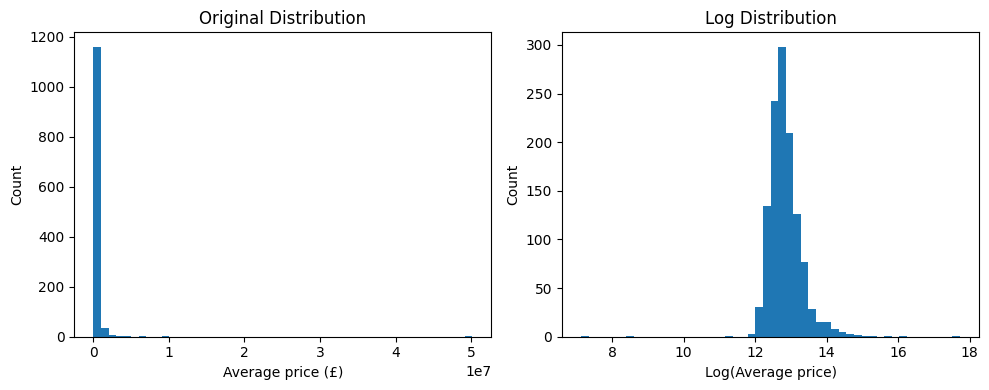

In [11]:
# 1.5 Distribution of avg_price (Original + Log)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
final_df["avg_price"].dropna().plot(kind="hist", bins=50)
plt.xlabel("Average price (£)")
plt.ylabel("Count")
plt.title("Original Distribution")

plt.subplot(1,2,2)
np.log(final_df["avg_price"].dropna().clip(lower=1)).plot(kind="hist", bins=50)
plt.xlabel("Log(Average price)")
plt.ylabel("Count")
plt.title("Log Distribution")

plt.tight_layout()
plt.show()

## Average House Prices by Year

This boxplot visualises the distribution of average house prices across postcode sectors for each year in the study period. A logarithmic scale is applied to the y-axis to accommodate the wide range of price values and improve comparability across years.

Median values, interquartile ranges, and outliers are displayed for each year, enabling year-by-year comparison of price distributions across postcode sectors.


<Figure size 1000x600 with 0 Axes>

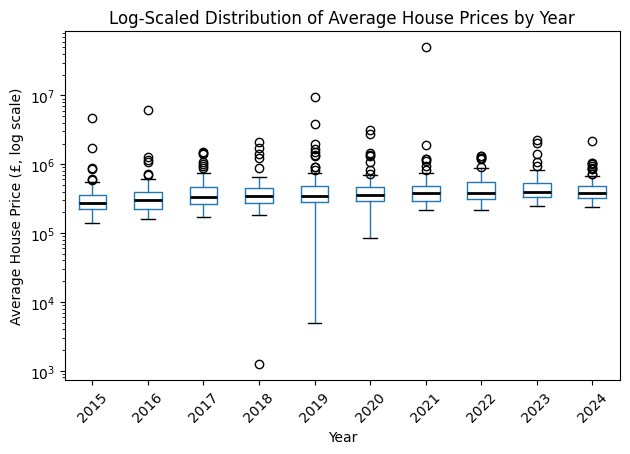

In [12]:
# 1.6 Boxplot of avg_price by year
plt.figure(figsize=(10, 6))

final_df.boxplot(
    column="avg_price",
    by="year",
    grid=False,
    showfliers=True,
    medianprops=dict(color="black", linewidth=2)
)

plt.yscale("log")
plt.title("Log-Scaled Distribution of Average House Prices by Year")
plt.suptitle("")
plt.xlabel("Year")
plt.ylabel("Average House Price (£, log scale)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Temporal Trend in Mean House Prices

This time series plot shows the annual mean of average house prices across Bristol postcode sectors from 2015 to 2024. Mean values are calculated by aggregating postcode sector prices for each year.

The visualisation supports comparison of price levels across years and provides a temporal overview of changes in average house prices over the study period.


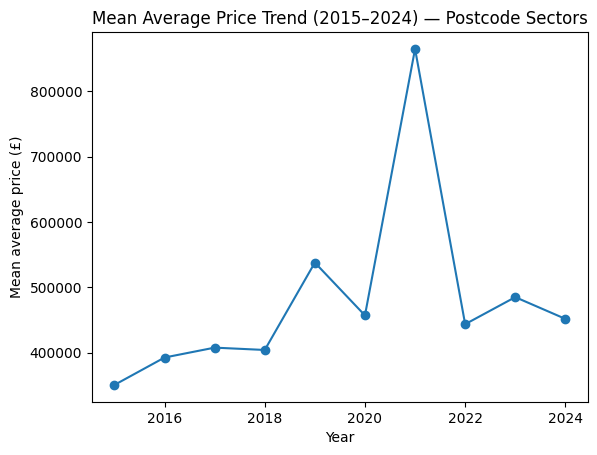

In [14]:
# 1.7 Time series of mean price
plt.figure()
final_df.groupby("year")["avg_price"].mean().plot(marker="o")
plt.xlabel("Year")
plt.ylabel("Mean average price (£)")
plt.title("Mean Average Price Trend (2015–2024) — Postcode Sectors")
plt.show()

## Relationship Between Sales Volume and House Prices

This scatter plot displays average house prices against transaction volume for each postcode sector. A logarithmic scale is applied to prices to accommodate skewness and improve visual clarity.

The visualisation enables inspection of the distribution of price levels across different transaction volumes and supports assessment of potential associations between market activity and price.


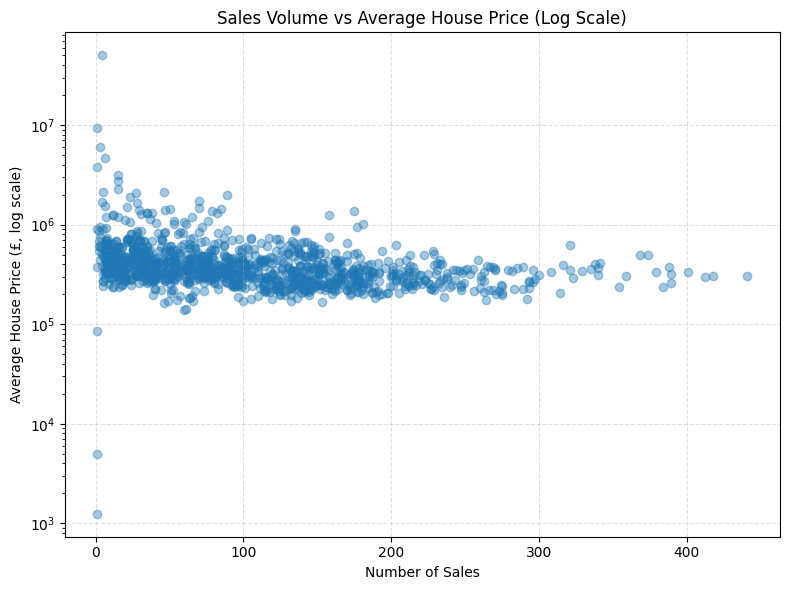

In [13]:
# 1.8 Scatter: sales vs price
plt.figure(figsize=(8, 6))

plt.scatter(
    final_df["n_sales"],
    final_df["avg_price"],
    alpha=0.4
)

plt.yscale("log")
plt.xlabel("Number of Sales")
plt.ylabel("Average House Price (£, log scale)")
plt.title("Sales Volume vs Average House Price (Log Scale)")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

## Spatial Distribution of Average House Prices

This spatial scatter plot maps postcode sectors using their centroid easting and northing coordinates. Each point represents a postcode sector, and points are coloured according to their average house price.

The visualisation provides a geographic overview of how average prices are distributed across space and supports exploratory assessment of spatial patterns within the study area.


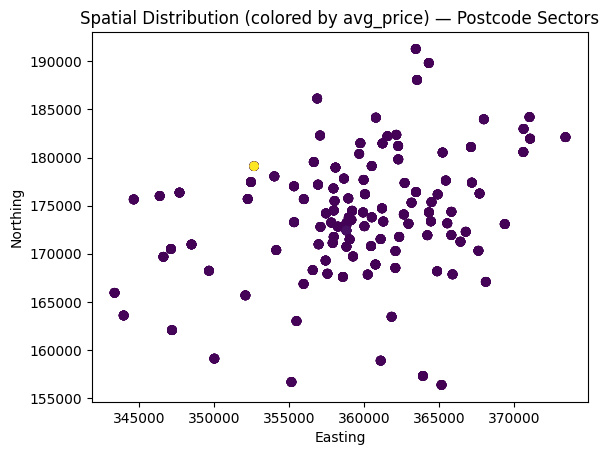

In [16]:
# 1.9 Spatial scatter (easting/northing colored by avg_price)
plt.figure()
plt.scatter(final_df["easting"], final_df["northing"], c=final_df["avg_price"])
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("Spatial Distribution (colored by avg_price) — Postcode Sectors")
plt.show()

## Correlation Analysis of Key Variables

This heatmap visualises pairwise Pearson correlation coefficients between key numerical variables in the dataset, including price measures, transaction volume, geographic coordinates, and population indicators.

Correlation values are displayed both through colour intensity and numeric labels within each cell, allowing direct comparison of the strength and direction of linear relationships between variables. This analysis supports preliminary assessment of potential multicollinearity and linear associations prior to modelling.


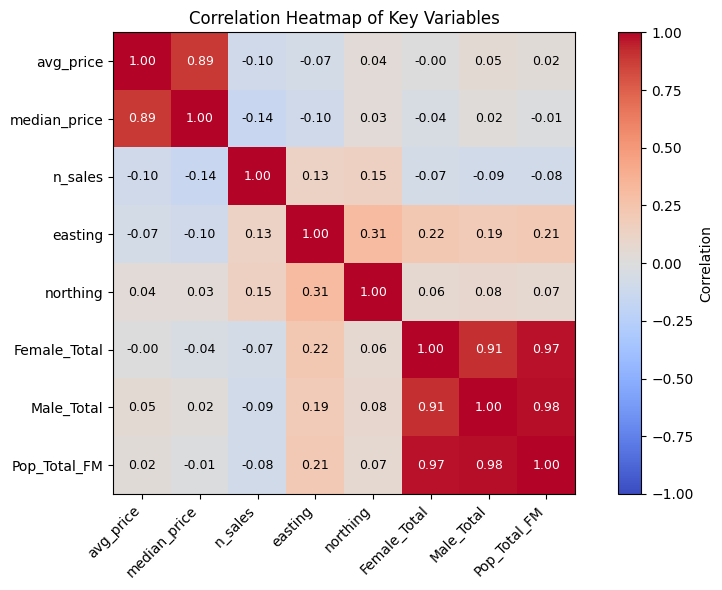

In [17]:
# ----------------------------
# Correlation heatmap (key variables)
# ----------------------------
key_corr_vars = [
    "avg_price",
    "median_price",
    "n_sales",
    "easting",
    "northing",
    "Female_Total",
    "Male_Total",
    "Pop_Total_FM"
]

corr_matrix = final_df[key_corr_vars].corr(numeric_only=True)

plt.figure(figsize=(9,6))
im = plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlation")

# Axis labels
plt.xticks(range(len(key_corr_vars)), key_corr_vars, rotation=45, ha="right")
plt.yticks(range(len(key_corr_vars)), key_corr_vars)

# Add values inside cells
for i in range(len(key_corr_vars)):
    for j in range(len(key_corr_vars)):
        value = corr_matrix.iloc[i, j]
        plt.text(
            j, i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color="black" if abs(value) < 0.6 else "white",
            fontsize=9
        )

plt.title("Correlation Heatmap of Key Variables")
plt.tight_layout()
plt.show()

## Correlation Strength with Average House Prices

This analysis computes Pearson correlation coefficients between average house prices and all other numeric variables in the dataset. The results are sorted to identify variables with the strongest linear associations with average price.

A horizontal bar chart visualises the top correlations, allowing direct comparison of the relative strength and direction of relationships between average house prices and selected predictors.



--- TOP CORRELATIONS WITH avg_price ---
avg_price       1.000000
median_price    0.886010
Male_Total      0.050984
northing        0.036970
year            0.032937
Pop_Total_FM    0.024894
Female_Total   -0.004413
easting        -0.066158
n_sales        -0.097287
Name: avg_price, dtype: float64


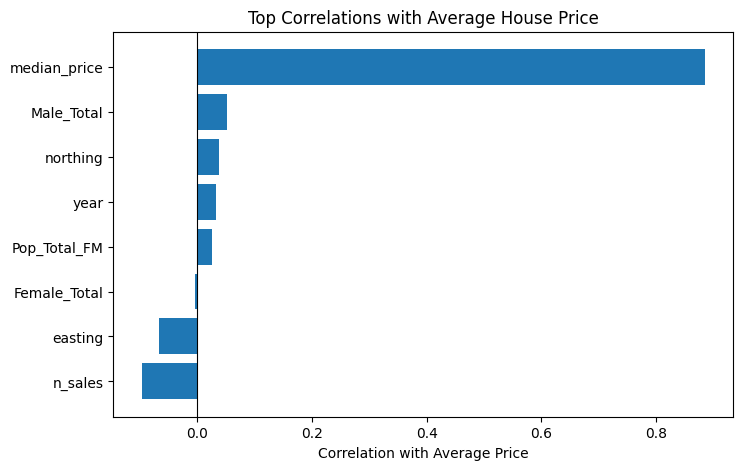

In [18]:
# 1.10 Correlations with avg_price (numeric)
num_df = final_df.select_dtypes(include=[np.number]).copy()
corr = num_df.corr(numeric_only=True)["avg_price"].sort_values(ascending=False)
print("\n--- TOP CORRELATIONS WITH avg_price ---")
print(corr.head(15))

# ----------------------------
# Visualize top correlations with avg_price
# ----------------------------
top_corr = corr.drop("avg_price").head(12)

plt.figure(figsize=(8,5))
plt.barh(top_corr.index[::-1], top_corr.values[::-1])
plt.xlabel("Correlation with Average Price")
plt.title("Top Correlations with Average House Price")
plt.axvline(0, color="black", linewidth=0.8)
plt.show()

## Outlier Identification and Log Transformation

This step applies the interquartile range (IQR) rule to identify potential outliers in average house prices. Observations falling below 1.5×IQR below the first quartile or above 1.5×IQR above the third quartile are flagged and reported for inspection.

In addition, a log-transformed version of the average price variable is created and stored in the dataset to support more stable statistical analysis and modelling if required.


In [19]:
# 1.11 Outlier check (IQR rule on avg_price)
q1 = final_df["avg_price"].quantile(0.25)
q3 = final_df["avg_price"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

outliers = final_df[(final_df["avg_price"] < lower) | (final_df["avg_price"] > upper)]
print("\nOutliers by IQR rule:", outliers.shape[0], "rows")
print(outliers[["postcode_sector","year","avg_price"]].head())

# Optional: log transform target for stability (store in dataset)
final_df["log_avg_price"] = np.log(final_df["avg_price"].clip(lower=1))
print("\nAdded log_avg_price for optional modelling.")


Outliers by IQR rule: 78 rows
   postcode_sector  year     avg_price
4            BS1 1  2019  1.652299e+06
9            BS1 1  2023  9.348571e+05
11           BS1 2  2015  4.634815e+06
12           BS1 2  2016  1.264091e+06
14           BS1 2  2018  1.403329e+06

Added log_avg_price for optional modelling.


## Distribution of Total Population by Postcode Sector

These histograms display the distribution of total population across postcode sectors using both the original scale and a logarithmic scale. Total population is calculated as the sum of female and male residents for each sector.

The log-transformed plot is included to reduce skewness and support clearer visualisation of population variation across postcode sectors.


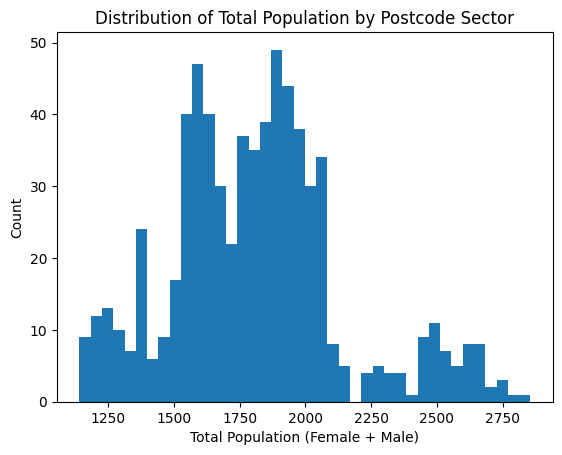

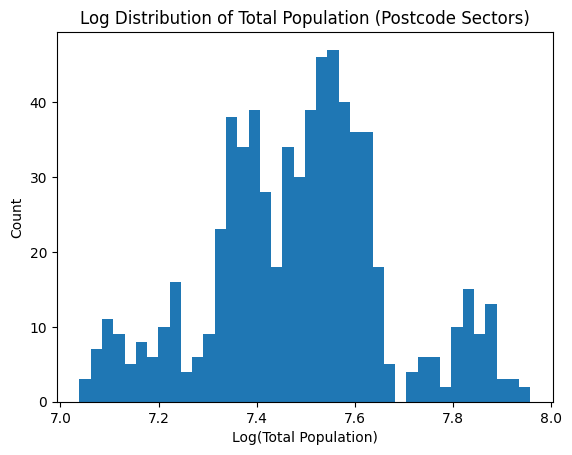

In [20]:
# =========================
# ONS EDA — POSTCODE SECTOR VERSION
# =========================

# 1.12 Total population distribution
plt.figure()
final_df["Pop_Total_FM"].dropna().plot(kind="hist", bins=40)
plt.xlabel("Total Population (Female + Male)")
plt.ylabel("Count")
plt.title("Distribution of Total Population by Postcode Sector")
plt.show()

# Log distribution of population
plt.figure()
np.log(final_df["Pop_Total_FM"].dropna().clip(lower=1)).plot(kind="hist", bins=40)
plt.xlabel("Log(Total Population)")
plt.ylabel("Count")
plt.title("Log Distribution of Total Population (Postcode Sectors)")
plt.show()

## Gender Composition by Postcode Sector

This analysis examines gender composition across postcode sectors using two visualisations. A scatter plot compares total female and male populations, allowing inspection of balance and relative differences between sectors.

In addition, the female-to-male population ratio is calculated and displayed as a histogram to summarise the distribution of gender balance across postcode sectors.


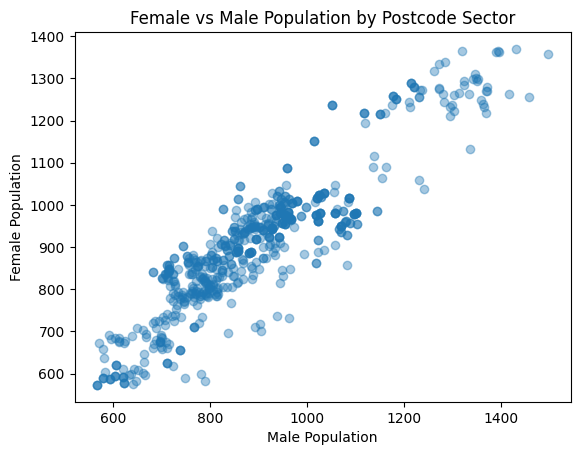

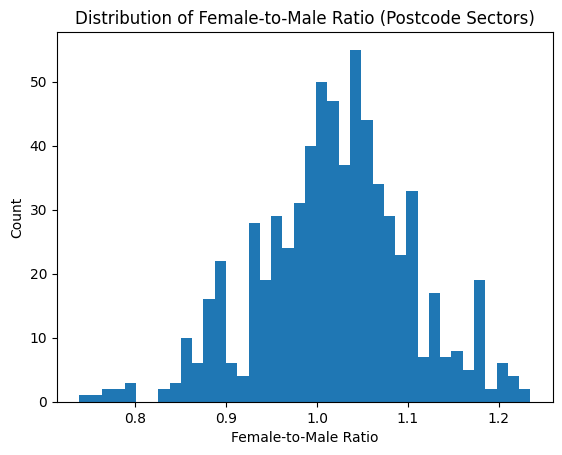

In [21]:
# 1.13 Gender composition analysis
# Female vs Male population (scatter)
plt.figure()
plt.scatter(
    final_df["Male_Total"],
    final_df["Female_Total"],
    alpha=0.4
)
plt.xlabel("Male Population")
plt.ylabel("Female Population")
plt.title("Female vs Male Population by Postcode Sector")
plt.show()

# Gender ratio distribution
final_df["female_male_ratio"] = final_df["Female_Total"] / final_df["Male_Total"]

plt.figure()
final_df["female_male_ratio"].dropna().plot(kind="hist", bins=40)
plt.xlabel("Female-to-Male Ratio")
plt.ylabel("Count")
plt.title("Distribution of Female-to-Male Ratio (Postcode Sectors)")
plt.show()

## Relationship Between Population and House Prices

These scatter plots explore the relationship between total population and average house prices at the postcode sector level. The first plot shows the relationship on the original scale, comparing total population counts with average house prices.

A second plot applies a logarithmic transformation to both variables, allowing inspection of the association under a log–log scale and facilitating comparison where both population and prices exhibit skewed distributions.


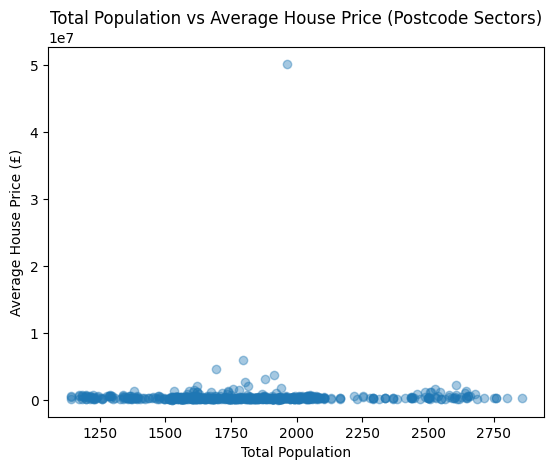

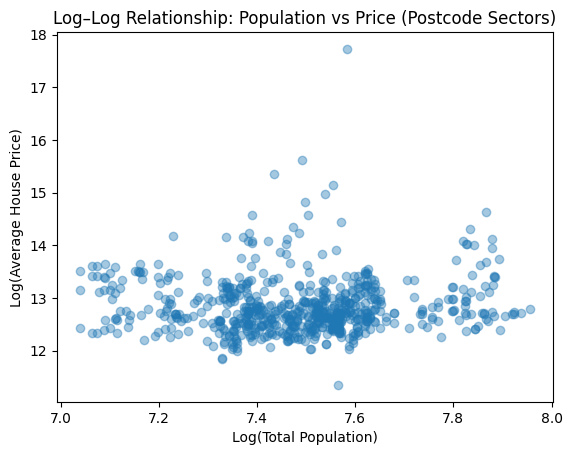

In [22]:
# 1.14 Relationship between ONS population and house prices
# Total population vs average price
plt.figure()
plt.scatter(
    final_df["Pop_Total_FM"],
    final_df["avg_price"],
    alpha=0.4
)
plt.xlabel("Total Population")
plt.ylabel("Average House Price (£)")
plt.title("Total Population vs Average House Price (Postcode Sectors)")
plt.show()

# Log–log relationship
plt.figure()
plt.scatter(
    np.log(final_df["Pop_Total_FM"].clip(lower=1)),
    np.log(final_df["avg_price"].clip(lower=1)),
    alpha=0.4
)
plt.xlabel("Log(Total Population)")
plt.ylabel("Log(Average House Price)")
plt.title("Log–Log Relationship: Population vs Price (Postcode Sectors)")
plt.show()

## Population Trends Over Time

This analysis examines temporal changes in population across Bristol postcode sectors. The first line plot shows the annual mean total population, aggregated across sectors, providing an overview of population trends over the study period.

A second visualisation combines mean population and mean average house prices using dual axes, allowing comparison of their respective trends over time within a single figure.


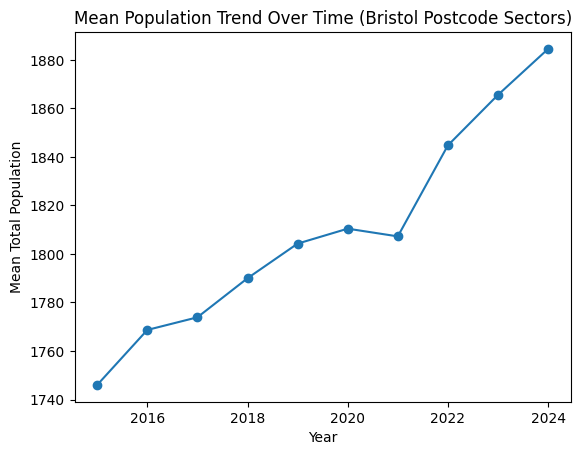

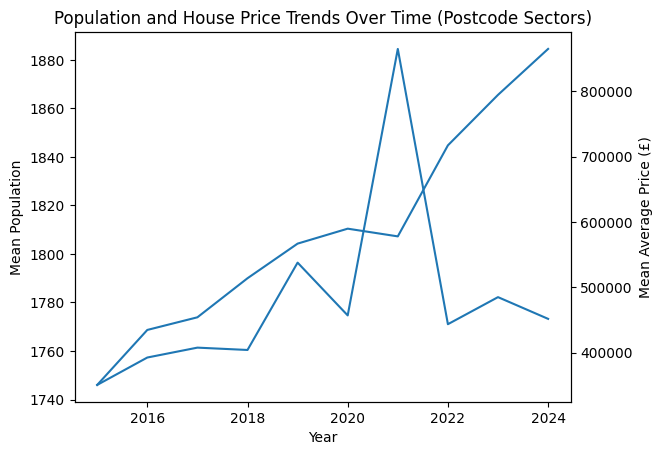

In [23]:
# 1.15 Population change over time (ONS + temporal insight)
# Mean population trend over time
pop_trend = final_df.groupby("year")["Pop_Total_FM"].mean()

plt.figure()
pop_trend.plot(marker="o")
plt.xlabel("Year")
plt.ylabel("Mean Total Population")
plt.title("Mean Population Trend Over Time (Bristol Postcode Sectors)")
plt.show()

# Population vs price trend together (dual plots)
fig, ax1 = plt.subplots()

ax1.plot(final_df.groupby("year")["Pop_Total_FM"].mean())
ax1.set_xlabel("Year")
ax1.set_ylabel("Mean Population")

ax2 = ax1.twinx()
ax2.plot(final_df.groupby("year")["avg_price"].mean())
ax2.set_ylabel("Mean Average Price (£)")

plt.title("Population and House Price Trends Over Time (Postcode Sectors)")
plt.show()

## Spatial Distribution of Population and Gender Ratio

These spatial scatter plots map postcode sectors using centroid easting and northing coordinates. The first plot colours sectors by total population, providing a geographic overview of population distribution across Bristol.

The second plot visualises the spatial distribution of the female-to-male population ratio, enabling inspection of geographic variation in gender balance across postcode sectors.


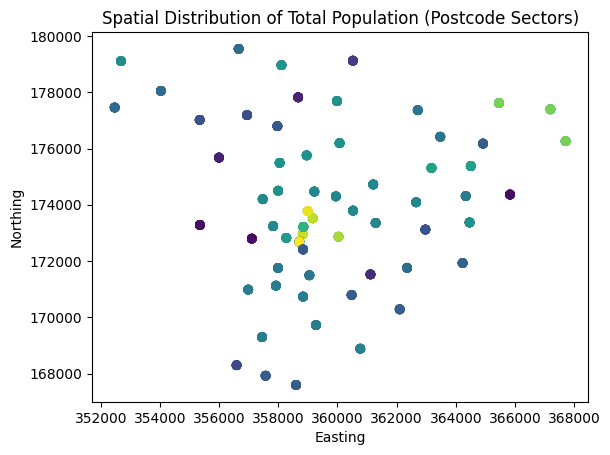

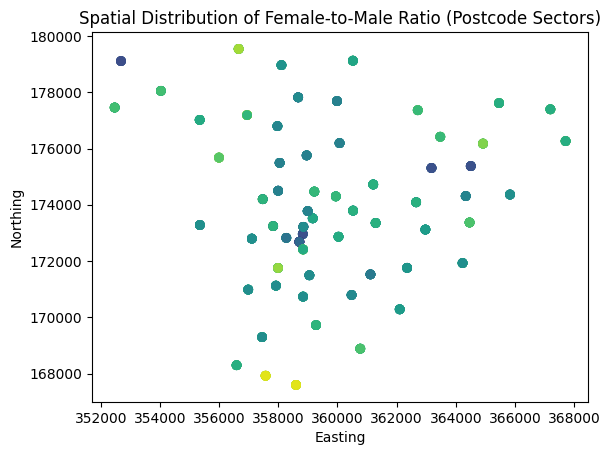

In [24]:
# 1.16 Spatial population patterns (ONS + geography)
# Spatial distribution of population
plt.figure()
plt.scatter(
    final_df["easting"],
    final_df["northing"],
    c=final_df["Pop_Total_FM"],
)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("Spatial Distribution of Total Population (Postcode Sectors)")
plt.show()

# Spatial distribution of gender ratio
plt.figure()
plt.scatter(
    final_df["easting"],
    final_df["northing"],
    c=final_df["female_male_ratio"],
)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("Spatial Distribution of Female-to-Male Ratio (Postcode Sectors)")
plt.show()

In [25]:
# ============================================================
# Imports for Modelling & Evaluation
# ============================================================

# ----------------------------
# Scikit-learn core
# ----------------------------
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# ----------------------------
# Preprocessing
# ----------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ----------------------------
# Metrics
# ----------------------------
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# ----------------------------
# Models
# ----------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# ----------------------------
# Model interpretation
# ----------------------------
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate


## Feature Selection and Train–Test Split

This section defines the input features and target variable used for modelling average house prices at the postcode sector level. Numeric features include geographic coordinates, transaction volume, and population indicators, while year is treated as a categorical feature to capture temporal effects.

The dataset is then split into training and testing subsets using an 80/20 split. Observations with missing target values are excluded to ensure consistency during model training and evaluation.

In [26]:
# ============================================================
# MODELLING — POSTCODE SECTOR VERSION
# (Only change needed: use postcode_sector when saving outputs later)
# Your features (easting/northing/n_sales + ONS totals + year) stay the same.
# ============================================================

# ----------------------------
# 1) Choose features + target
# ----------------------------
numeric_features = ["easting","northing","n_sales","Female_Total","Male_Total","Pop_Total_FM"]
categorical_features = ["year"]  # treat year as categorical (often helps)

TARGET = "avg_price"  # try "log_avg_price" if you created it earlier

X = final_df[numeric_features + categorical_features].copy()
y = final_df[TARGET].copy()

# drop missing target
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Data Preprocessing Pipeline

This step defines a preprocessing pipeline to prepare features for modelling. Numeric variables are processed using median imputation for missing values followed by standardisation, while categorical variables are imputed using the most frequent category and encoded using one-hot encoding.

The numeric and categorical pipelines are combined using a column transformer, ensuring that all features are consistently prepared before being passed to the predictive models.


In [27]:
# ----------------------------
# 2) Preprocessing
# ----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

## Model Definition, Training, and Evaluation

This section defines a set of baseline and machine-learning regression models used to predict average house prices, including linear regression, regularised linear models (Ridge and Lasso), gradient boosting, and a Random Forest model. These models were selected to enable comparison between linear and non-linear approaches under a consistent experimental setup.

Each model is combined with the preprocessing pipeline into a single workflow and trained on the training dataset. Predictions are generated on the test set and evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R². Model performance results are compiled into a summary table for comparison.


In [28]:
# ----------------------------
# 3) Define models (fast set)
# ----------------------------
models_fast = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(
        random_state=42, max_depth=6, learning_rate=0.05, max_iter=200
    ),
    "RandomForest_fast": RandomForestRegressor(
        n_estimators=150, random_state=42, n_jobs=-1,
        max_depth=20, min_samples_leaf=3
    )
}

# ============================
# Evaluation function
# ============================
def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


# ============================
# Fit + evaluate models
# ============================
results = []
fitted_pipes = {}

for name, model in models_fast.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", model)
        ]
    )

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae, rmse, r2 = eval_metrics(y_test, preds)

    results.append([name, mae, rmse, r2])
    fitted_pipes[name] = pipe


# ============================
# Create results DataFrame
# ============================
results_df = (
    pd.DataFrame(
        results,
        columns=["Model", "MAE", "RMSE", "R2"]
    )
    .sort_values("RMSE")
    .reset_index(drop=True)
)


# ============================
# Print as pretty table
# ============================
print("\n=== MODEL PERFORMANCE (TEST SET) ===\n")

print(
    tabulate(
        results_df,
        headers="keys",
        tablefmt="pretty",
        floatfmt=".2f",
        showindex=True
    )
)



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+15, tolerance: 2.677e+11
  model = cd_fast.enet_coordinate_descent(



=== MODEL PERFORMANCE (TEST SET) ===

+---+----------------------+--------------------+--------------------+---------------------+
|   |        Model         |        MAE         |        RMSE        |         R2          |
+---+----------------------+--------------------+--------------------+---------------------+
| 0 |  RandomForest_fast   | 126524.93617807563 | 376402.6273968634  | -1.0370850483485854 |
| 1 |        Ridge         | 285884.96222082275 | 385901.0258345652  | -1.141192604795859  |
| 2 |        Lasso         | 288160.3069610027  | 387731.31363615656 | -1.161551671711329  |
| 3 | HistGradientBoosting | 182543.55713945744 | 389265.97013776243 | -1.1786965557821456 |
| 4 |   LinearRegression   | 292020.01907723304 | 391853.28548060445 | -1.207754880757948  |
+---+----------------------+--------------------+--------------------+---------------------+


## Model Performance Comparison

These figures present a visual comparison of model performance on the test dataset. The first bar chart displays Root Mean Squared Error (RMSE) values for each model, enabling comparison of average prediction error magnitude.

The second bar chart shows R² values, illustrating the relative explanatory power of each model. Together, these plots support direct comparison between linear and non-linear models and help identify the most effective approach for predicting average house prices at postcode sector level.


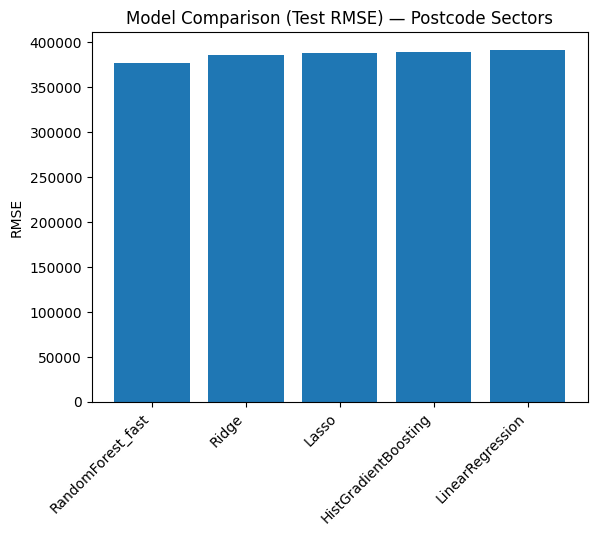

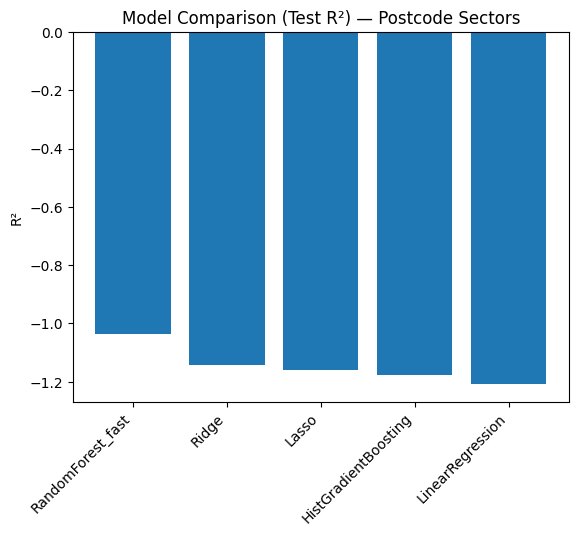

In [29]:
# ----------------------------
# 4b) Plot model comparison (RMSE + R2)
# ----------------------------
plt.figure()
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.title("Model Comparison (Test RMSE) — Postcode Sectors")
plt.show()

plt.figure()
plt.bar(results_df["Model"], results_df["R2"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("R²")
plt.title("Model Comparison (Test R²) — Postcode Sectors")
plt.show()

## Best Model Selection and Performance

This step identifies the best-performing model based on test RMSE and selects it for further analysis. The selected model is used to generate predictions on the test dataset.

Performance metrics including MAE, RMSE, and R² are then reported for the chosen model, providing a concise summary of its predictive accuracy and explanatory performance.


In [38]:
# ----------------------------
# 4c) Select best model + predictions
# ----------------------------
best_model_name = results_df.iloc[0]["Model"]
best_pipe = fitted_pipes[best_model_name]

best_pred = best_pipe.predict(X_test)

best_mae, best_rmse, best_r2 = eval_metrics(y_test, best_pred)
print("\n=== BEST MODEL (Postcode Sectors) ===")
print("Best model:", best_model_name)
print("MAE:", best_mae)
print("RMSE:", best_rmse)
print("R²:", best_r2)


=== BEST MODEL (Postcode Sectors) ===
Best model: RandomForest_fast
MAE: 126524.93617807563
RMSE: 376402.6273968634
R²: -1.0370850483485854


## Actual vs Predicted Prices

This scatter plot compares observed average house prices with values predicted by the selected best-performing model. Each point represents a postcode sector in the test set.

The diagonal reference line indicates perfect prediction, allowing visual assessment of model accuracy, systematic bias, and dispersion across different price ranges.


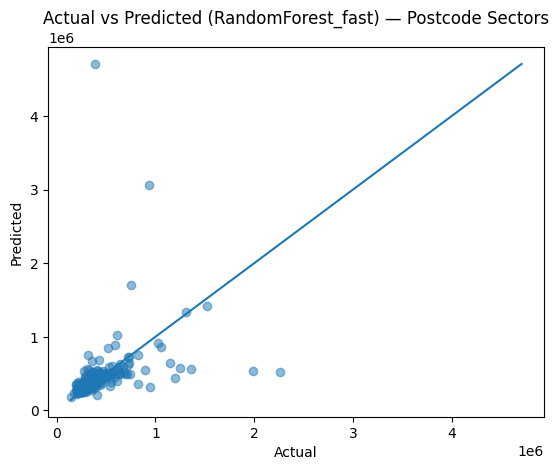

In [39]:
# ----------------------------
# 4d) Actual vs Predicted scatter plot (best model)
# ----------------------------
plt.figure()
plt.scatter(y_test, best_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted ({best_model_name}) — Postcode Sectors")
minv = min(y_test.min(), best_pred.min())
maxv = max(y_test.max(), best_pred.max())
plt.plot([minv, maxv], [minv, maxv])
plt.show()

## Residual Analysis

This code computes residuals as the difference between actual and predicted average house prices from the best-performing model. A residual scatter plot is generated to visualise how prediction errors vary across predicted values, with a horizontal reference line at zero to indicate perfect predictions.

In addition, a histogram of residuals is plotted to examine the overall distribution of errors and assess symmetry, spread, and the presence of extreme residuals.


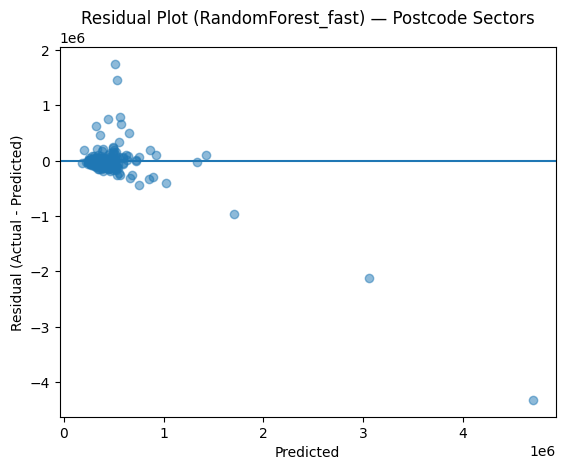

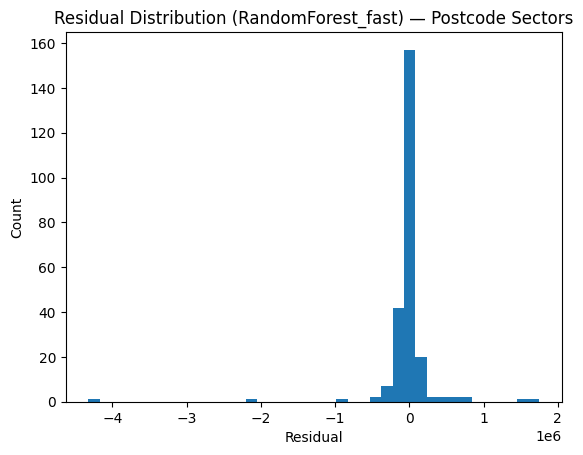

In [40]:
# ----------------------------
# 4e) Residual plot (best model)
# ----------------------------
residuals = y_test - best_pred

plt.figure()
plt.scatter(best_pred, residuals, alpha=0.5)
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residual Plot ({best_model_name}) — Postcode Sectors")
plt.axhline(0)
plt.show()

plt.figure()
plt.hist(residuals, bins=40)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title(f"Residual Distribution ({best_model_name}) — Postcode Sectors")
plt.show()

## Temporal Model Performance by Year

This code evaluates the performance of the best-performing model separately for each year in the test dataset. Predicted values, actual prices, and residuals are combined into a single dataframe to enable year-wise comparison.

For each year, standard evaluation metrics (MAE, RMSE, and R²) are calculated to assess how model accuracy varies over time. A line plot of RMSE by year is then produced to visualise temporal changes in predictive performance and identify periods of instability or reduced accuracy.



=== Performance by year (best model) — Postcode Sectors ===
   year            MAE           RMSE        R2     N
0  2015   92281.392992  115693.655299  0.538707  23.0
1  2016   84566.950228  131798.939743  0.551487  24.0
2  2017   85129.422227  156489.608915  0.717770  22.0
3  2018   72880.874344  149039.749497  0.452016  23.0
4  2019  139963.126713  359139.592131  0.201088  22.0
5  2020   59413.790437   93565.493878  0.761793  23.0
6  2021   53465.700076   84122.250050  0.573312  25.0
7  2022  252340.301986  810393.011634 -9.613118  30.0
8  2023  194877.479628  435421.146759 -0.195146  23.0
9  2024  190637.839041  442529.705194 -4.749114  26.0


/tmp/ipython-input-1777304875.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_perf = pred_df.groupby("year").apply(


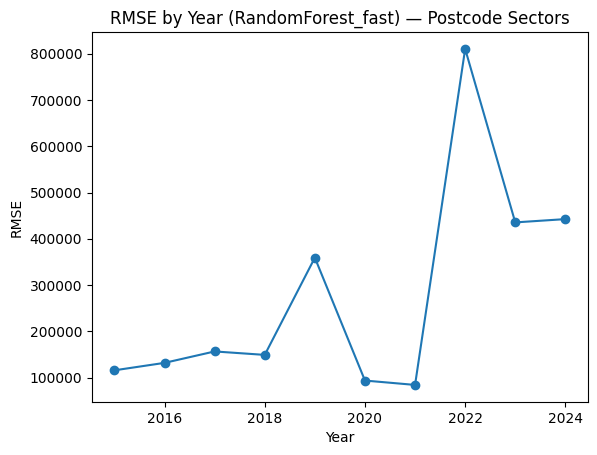

In [41]:
# ----------------------------
# 4f) Performance by year (best model)
# ----------------------------
pred_df = X_test.copy().reset_index(drop=True)
pred_df["actual"] = np.array(y_test)
pred_df["predicted"] = best_pred
pred_df["residual"] = pred_df["actual"] - pred_df["predicted"]

if "year" in pred_df.columns:
    year_perf = pred_df.groupby("year").apply(
        lambda d: pd.Series({
            "MAE": mean_absolute_error(d["actual"], d["predicted"]),
            "RMSE": np.sqrt(mean_squared_error(d["actual"], d["predicted"])),
            "R2": r2_score(d["actual"], d["predicted"]) if len(d) > 1 else np.nan,
            "N": len(d)
        })
    ).reset_index()

    print("\n=== Performance by year (best model) — Postcode Sectors ===")
    print(year_perf)

    plt.figure()
    plt.plot(year_perf["year"], year_perf["RMSE"], marker="o")
    plt.xlabel("Year")
    plt.ylabel("RMSE")
    plt.title(f"RMSE by Year ({best_model_name}) — Postcode Sectors")
    plt.show()

## Permutation Feature Importance

This code applies permutation importance to the selected best-performing model to assess the contribution of each input feature to predictive performance. The method measures the change in model error when the values of a single feature are randomly permuted, with larger increases in error indicating greater importance.

Feature importance scores (mean and standard deviation across repetitions) are computed for geographic, transactional, demographic, and temporal variables. The results are summarised in a table and visualised using a horizontal bar chart to support interpretation of which features most strongly influence model predictions.


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['easting', 'northing', 'n_sales',
                                  'Female_Total', 'Male_Total',
                                  'Pop_Total_FM']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['year'])])
transformers_: [('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())]), ['easting', 'northing',

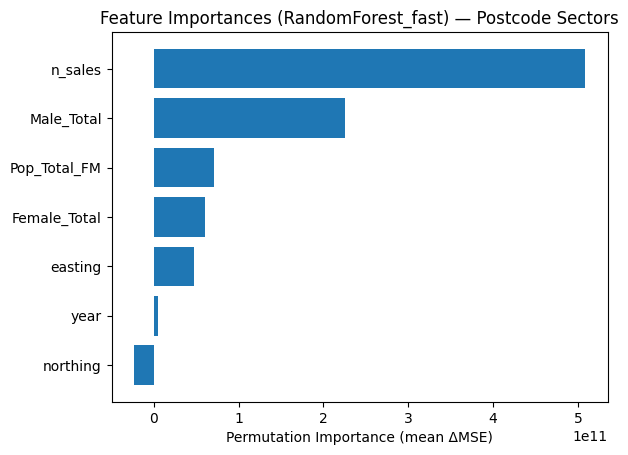

In [42]:
from sklearn.inspection import permutation_importance

# ----------------------------
# A) Permutation importance (sector model)
# ----------------------------
pre = best_pipe.named_steps["preprocess"]
print(pre)
print("transformers_:", getattr(pre, "transformers_", None))

perm = permutation_importance(
    best_pipe, X_test, y_test,
    n_repeats=5,
    random_state=42,
    scoring="neg_mean_squared_error"
)

imp = perm.importances_mean
imp_std = perm.importances_std

# Use ORIGINAL feature columns: 6 numeric + year
feature_names_7 = np.array([
    "easting",
    "northing",
    "n_sales",
    "Female_Total",
    "Male_Total",
    "Pop_Total_FM",
    "year"
], dtype=str)

# If order differs, use X_test columns
if len(imp) == len(X_test.columns):
    feature_names = np.array(X_test.columns, dtype=str)
else:
    feature_names = feature_names_7[:len(imp)]

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": imp,
    "importance_std": imp_std
}).sort_values("importance_mean", ascending=False)

print("\n=== Permutation importance ===")
print(imp_df)

plt.figure()
plt.barh(imp_df["feature"][::-1], imp_df["importance_mean"][::-1])
plt.xlabel("Permutation Importance (mean ΔMSE)")
plt.title(f"Feature Importances ({best_model_name}) — Postcode Sectors")
plt.show()

## Final Predictions and Ranking Preparation

This code applies the best-performing model to the full dataset to generate predicted average house prices for each postcode sector and year. Predicted values and residuals (actual minus predicted prices) are added to the dataset to support further evaluation and ranking analysis.

A sensitivity check is then performed to determine an appropriate minimum transaction count (`n_sales`) threshold for reliable sector ranking. Several candidate thresholds are tested, and a defensible minimum is selected to balance data reliability with spatial coverage, ensuring that rankings are based on sufficiently active housing markets.


In [43]:
# ============================================================
# FINAL PREDICTIONS + RANKINGS (postcode_sector × year)
# ============================================================

target_col = "avg_price"
df_model = final_df.copy()

# Build X used for prediction (same columns as training)
feature_cols = numeric_features + categorical_features
X_all = df_model[feature_cols].copy()

pred_col = f"pred_{best_model_name.lower()}"
resid_col = "residual"

df_model[pred_col] = best_pipe.predict(X_all)
df_model[resid_col] = df_model[target_col] - df_model[pred_col]

print("Predictions added:", pred_col)
print("df_model shape:", df_model.shape)

# ----------------------------
# Choose defensible minimum n_sales for ranking (sector)
# ----------------------------
candidates = [3, 5, 10, 15, 20, 25, 30]
min_rows_keep = max(200, int(0.60 * len(df_model)))  # sectors have fewer rows than units

keep_counts = []
for t in candidates:
    keep_n = (df_model["n_sales"] >= t).sum()
    keep_counts.append((t, keep_n))

print("\nRows kept by n_sales threshold:")
print(pd.DataFrame(keep_counts, columns=["threshold", "rows_kept"]))

chosen = None
for t, keep_n in reversed(keep_counts):
    if keep_n >= min_rows_keep:
        chosen = t
        break

if chosen is None:
    chosen = 5 if (df_model["n_sales"] >= 5).sum() > 0 else 3

MIN_TX_RANK = chosen
print("\n Chosen minimum n_sales for ranking:", MIN_TX_RANK)


Predictions added: pred_randomforest_fast
df_model shape: (1205, 15)

Rows kept by n_sales threshold:
   threshold  rows_kept
0          3       1194
1          5       1184
2         10       1133
3         15       1095
4         20       1052
5         25       1009
6         30        969

 Chosen minimum n_sales for ranking: 30


## Postcode-Sector Ranking Construction

This section constructs the final ranking dataset by filtering observations to postcode sectors that meet the selected minimum transaction threshold. Extreme values are optionally trimmed using lower and upper quantiles to reduce the influence of atypical price observations.

Sector-level rankings are then computed by aggregating across years to obtain mean actual prices, mean predicted prices, average residuals, total transaction counts, and temporal coverage. An additional reliability filter ensures that only postcode sectors with sufficient multi-year data are included in the final ranking table.


In [44]:
# ----------------------------
# Ranking dataset + optional trimming
# ----------------------------
df_rank = df_model[df_model["n_sales"] >= MIN_TX_RANK].copy()

LOW_Q, HIGH_Q = 0.01, 0.99
q_low = df_rank[target_col].quantile(LOW_Q)
q_high = df_rank[target_col].quantile(HIGH_Q)
df_rank = df_rank[(df_rank[target_col] >= q_low) & (df_rank[target_col] <= q_high)].copy()

print("\nRanking dataset shape (after filters):", df_rank.shape)

# ----------------------------
# Sector-level ranking across years (one row per postcode_sector)
# ----------------------------
sector_rank = (
    df_rank.groupby("postcode_sector", as_index=False)
      .agg(
          actual_mean=(target_col, "mean"),
          predicted_mean=(pred_col, "mean"),
          residual_mean=(resid_col, "mean"),
          total_sales=("n_sales", "sum"),
          years_covered=("year", "nunique")
      )
)

# Optional reliability: must appear in >= 3 years
sector_rank = sector_rank[sector_rank["years_covered"] >= 3].copy()

print("\nPostcode-sector ranking table:", sector_rank.shape)
print(sector_rank.head())



Ranking dataset shape (after filters): (950, 15)

Postcode-sector ranking table: (105, 6)
  postcode_sector    actual_mean  predicted_mean  residual_mean  total_sales  \
3           BS1 4  744869.471876   911498.565626 -166629.093750          243   
4           BS1 5  640667.335933   626907.740677   13759.595255          665   
5           BS1 6  886002.535293   753357.520980  132645.014313         1388   
6          BS10 5  311048.616667   355191.178415  -44142.561748          786   
7          BS10 6  271286.083442   332478.163552  -61192.080110         1422   

   years_covered  
3              4  
4              8  
5              7  
6              9  
7             10  


## Postcode-Sector Ranking Outputs

This code extracts and displays ranked lists of postcode sectors based on model predictions and residual behaviour. Using the sector-level ranking table, the top 10 most expensive and most affordable postcode sectors are identified according to their predicted mean house prices.

In addition, postcode sectors with the largest negative and positive mean residuals are reported to highlight areas where the model systematically over-predicts or under-predicts prices. These summaries support interpretive analysis of spatial patterns and model bias across different housing markets.


In [45]:
# Print top lists (sector)
# ----------------------------
# Recreate sector rankings
# ----------------------------
cols_show = [
    "postcode_sector",
    "actual_mean",
    "predicted_mean",
    "total_sales",
    "years_covered"
]

top_expensive = (
    sector_rank
    .sort_values("predicted_mean", ascending=False)
    .head(10)
)

top_affordable = (
    sector_rank
    .sort_values("predicted_mean", ascending=True)
    .head(10)
)

print("\nTOP 10 MOST EXPENSIVE POSTCODE SECTORS (PREDICTED)")
print(top_expensive[cols_show])

print("\nTOP 10 MOST AFFORDABLE POSTCODE SECTORS (PREDICTED)")
print(top_affordable[cols_show])


print("\nTOP 10 OVER-PREDICTED POSTCODE SECTORS (negative residuals)")
print(sector_rank.sort_values("residual_mean", ascending=True)[cols_show].head(10))

print("\nTOP 10 UNDER-PREDICTED POSTCODE SECTORS (positive residuals)")
print(sector_rank.sort_values("residual_mean", ascending=False)[cols_show].head(10))



TOP 10 MOST EXPENSIVE POSTCODE SECTORS (PREDICTED)
    postcode_sector    actual_mean  predicted_mean  total_sales  years_covered
52           BS32 4  925340.465742   965668.766925          394              6
3             BS1 4  744869.471876   911498.565626          243              4
63           BS35 4  586698.476798   765512.027727          433              6
5             BS1 6  886002.535293   753357.520980         1388              7
104           BS8 3  712690.182132   663627.067553         1012              9
4             BS1 5  640667.335933   626907.740677          665              8
106           BS9 1  655835.312412   624859.615941         1015              9
31            BS2 0  589498.987349   605334.117943          948              9
102           BS8 1  545131.760448   568516.201621          562              8
98            BS6 7  610791.275577   560526.740110         1195             10

TOP 10 MOST AFFORDABLE POSTCODE SECTORS (PREDICTED)
   postcode_sector    actu

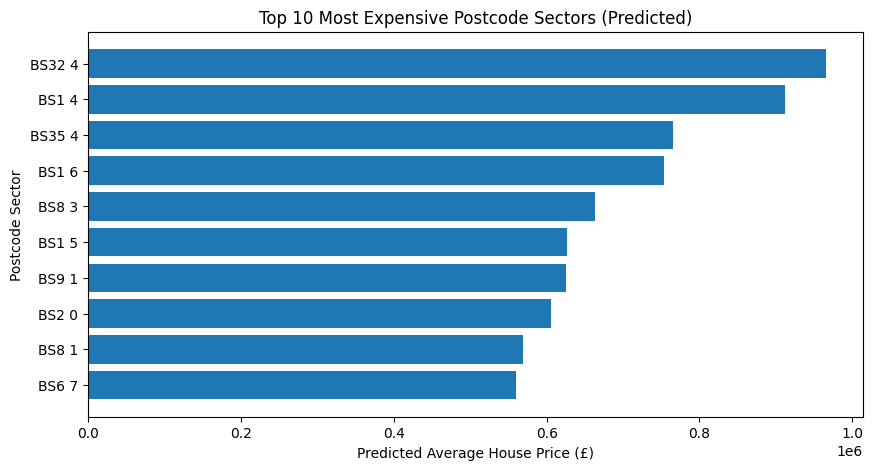

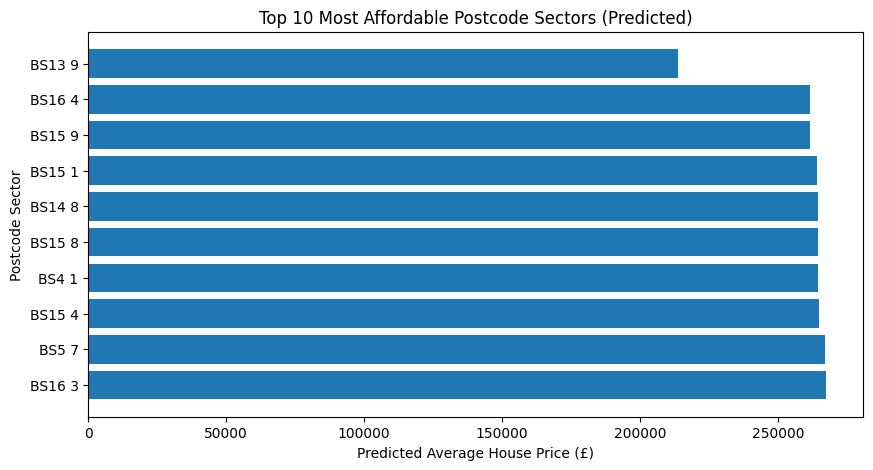

In [46]:
# Top 10 most expensive sectors

plt.figure(figsize=(10,5))

plt.barh(
    top_expensive["postcode_sector"][::-1],
    top_expensive["predicted_mean"][::-1]
)

plt.xlabel("Predicted Average House Price (£)")
plt.ylabel("Postcode Sector")
plt.title("Top 10 Most Expensive Postcode Sectors (Predicted)")
plt.show()


# Top 10 most affordable sectors

plt.figure(figsize=(10,5))

plt.barh(
    top_affordable["postcode_sector"][::-1],
    top_affordable["predicted_mean"][::-1]
)

plt.xlabel("Predicted Average House Price (£)")
plt.ylabel("Postcode Sector")
plt.title("Top 10 Most Affordable Postcode Sectors (Predicted)")
plt.show()


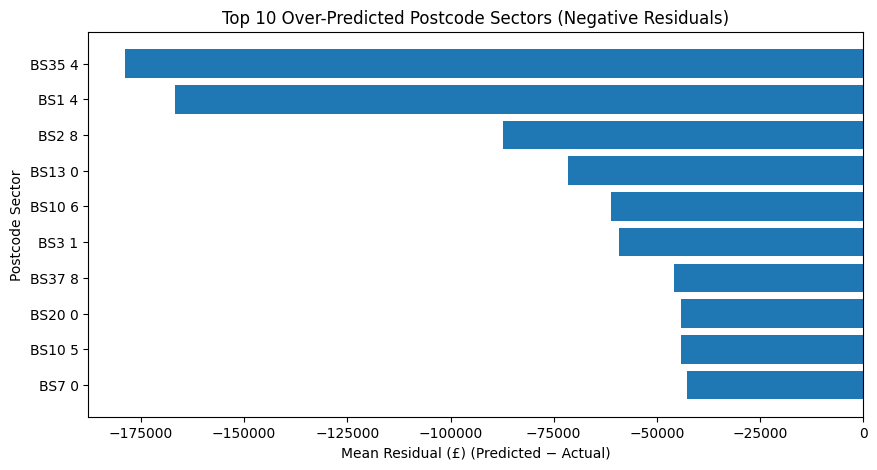

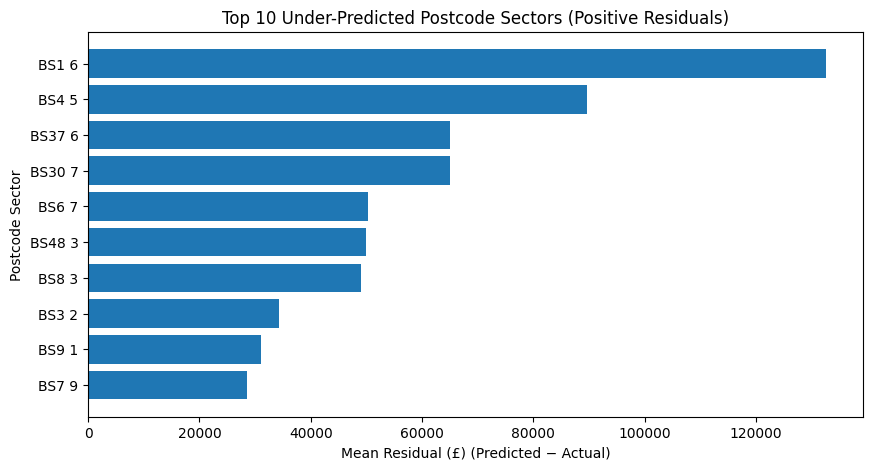

In [47]:
# Top 10 over-predicted postcode sectors (negative residuals)

top_over_predicted = (
    sector_rank
    .sort_values("residual_mean", ascending=True)
    .head(10)
)

plt.figure(figsize=(10,5))

plt.barh(
    top_over_predicted["postcode_sector"][::-1],
    top_over_predicted["residual_mean"][::-1]
)

plt.xlabel("Mean Residual (£) (Predicted − Actual)")
plt.ylabel("Postcode Sector")
plt.title("Top 10 Over-Predicted Postcode Sectors (Negative Residuals)")
plt.show()

# Top 10 under-predicted postcode sectors (positive residuals)

top_under_predicted = (
    sector_rank
    .sort_values("residual_mean", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))

plt.barh(
    top_under_predicted["postcode_sector"][::-1],
    top_under_predicted["residual_mean"][::-1]
)

plt.xlabel("Mean Residual (£) (Predicted − Actual)")
plt.ylabel("Postcode Sector")
plt.title("Top 10 Under-Predicted Postcode Sectors (Positive Residuals)")
plt.show()

## Actual vs Predicted Mean Prices (Sector Level)

This scatter plot compares the observed mean house prices with the model-predicted mean prices for each postcode sector. Each point represents a sector aggregated across years.

The diagonal reference line indicates perfect agreement, enabling visual assessment of overall alignment, systematic bias, and deviations between actual and predicted prices at the sector level.


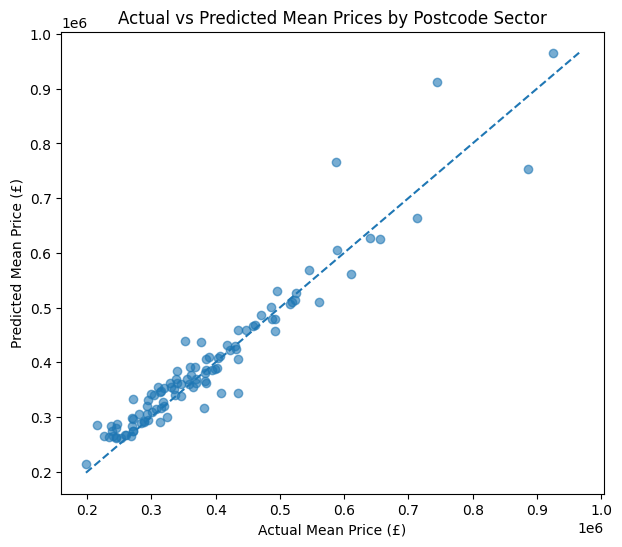

In [48]:
# Compare actual vs predicted (EDA diagnostic)
plt.figure(figsize=(7,6))

plt.scatter(
    sector_rank["actual_mean"],
    sector_rank["predicted_mean"],
    alpha=0.6
)

minv = min(sector_rank["actual_mean"].min(), sector_rank["predicted_mean"].min())
maxv = max(sector_rank["actual_mean"].max(), sector_rank["predicted_mean"].max())

plt.plot([minv, maxv], [minv, maxv], linestyle="--")

plt.xlabel("Actual Mean Price (£)")
plt.ylabel("Predicted Mean Price (£)")
plt.title("Actual vs Predicted Mean Prices by Postcode Sector")
plt.show()


## Distribution of Predicted Mean Prices

This code visualises the spread of model-predicted mean house prices across postcode sectors using both the original price scale and a logarithmic scale. Histograms are generated to examine overall dispersion and skewness in predicted values.

The log-transformed distribution is included to reduce the influence of extreme values and to support comparison with earlier distributional analyses conducted during exploratory data analysis.


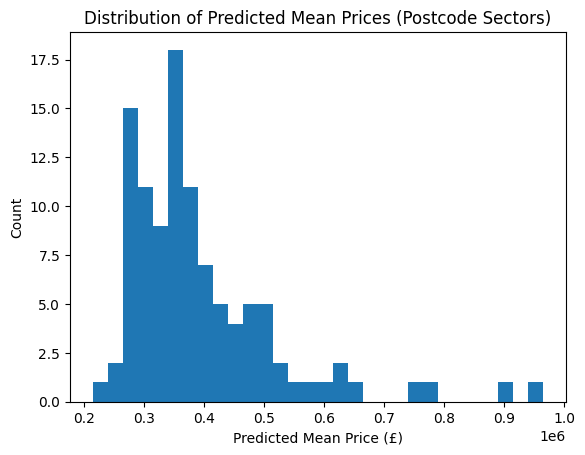

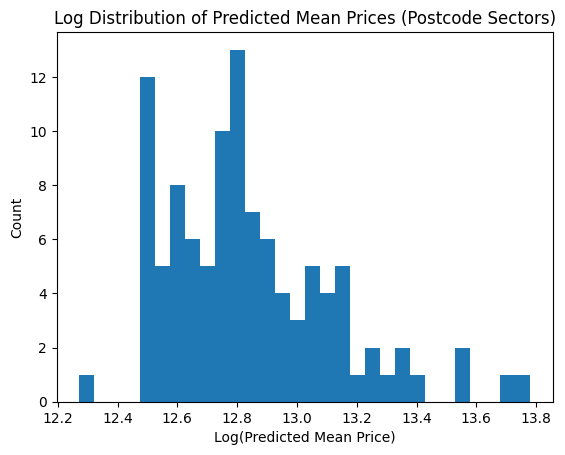

In [49]:
# Price spread across sectors

plt.figure()
sector_rank["predicted_mean"].plot(kind="hist", bins=30)
plt.xlabel("Predicted Mean Price (£)")
plt.ylabel("Count")
plt.title("Distribution of Predicted Mean Prices (Postcode Sectors)")
plt.show()

plt.figure()
np.log(sector_rank["predicted_mean"].clip(lower=1)).plot(kind="hist", bins=30)
plt.xlabel("Log(Predicted Mean Price)")
plt.ylabel("Count")
plt.title("Log Distribution of Predicted Mean Prices (Postcode Sectors)")
plt.show()


## Spatial Clustering and Map Preparation (Postcode Sectors)

This section prepares postcode sector data for spatial clustering and mapping. Easting and northing coordinates (OSGB36 / EPSG:27700) are converted into latitude and longitude (WGS84 / EPSG:4326) using `pyproj`, enabling geographic visualisation.

The dataset is then cleaned to remove invalid coordinate values and filtered to a reasonable Bristol bounding box to ensure only relevant locations are clustered. KMeans clustering is applied to latitude and longitude coordinates to group postcode sectors into six spatial clusters.

Finally, the code verifies that a predicted price column is available for mapping. If predictions have not already been generated for the clustering dataset, the best-performing model is applied to create them, ensuring each postcode sector has both a cluster label and a predicted price for the final map output.


In [44]:
# ============================================================
# FINAL MAP OUTPUT — POSTCODE SECTORS (BS sectors)
# ============================================================

# 1) Convert Easting/Northing → Latitude/Longitude
!pip -q install pyproj
from pyproj import Transformer
import numpy as np
import pandas as pd

transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True)

df_model = final_df.copy()

df_model["lon"], df_model["lat"] = transformer.transform(
    df_model["easting"].values,
    df_model["northing"].values
)

print("Lat/Lon created (sectors).")

# 2) Prepare data for clustering (clean lat/lon)
from sklearn.cluster import KMeans

df_cluster = df_model.copy()
df_cluster["lat"] = pd.to_numeric(df_cluster["lat"], errors="coerce")
df_cluster["lon"] = pd.to_numeric(df_cluster["lon"], errors="coerce")

df_cluster = df_cluster.replace([np.inf, -np.inf], np.nan)
df_cluster = df_cluster.dropna(subset=["lat", "lon"]).copy()

# Bristol bounds safety
df_cluster = df_cluster[
    df_cluster["lat"].between(51.0, 52.2) &
    df_cluster["lon"].between(-3.5, -2.0)
].copy()

print("Rows available for clustering:", df_cluster.shape[0])

coords = df_cluster[["lat", "lon"]].to_numpy(dtype=np.float64)

# 3) KMeans clustering
K = 6
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_cluster["cluster"] = kmeans.fit_predict(coords)

print("Clusters assigned.")
df_cluster[["postcode_sector", "lat", "lon", "cluster"]].head()

# 4) Ensure prediction column exists in df_cluster
import re

if "pred_col" not in globals():
    pred_col = f"pred_{best_model_name.lower()}"

# If no pred column exists, create predictions now (sector features)
if pred_col not in df_cluster.columns:
    pred_candidates = [c for c in df_cluster.columns if re.match(r"^pred_", str(c))]
    print("Available prediction columns:", pred_candidates)

    if not pred_candidates:
        print("No pred_* column found. Creating predictions now...")

        feature_cols = numeric_features + categorical_features
        X_map = df_cluster[feature_cols].copy()
        df_cluster[pred_col] = best_pipe.predict(X_map)

        print("Created:", pred_col)
    else:
        pred_col = pred_candidates[0]
        print("Using prediction column:", pred_col)

print("Using pred_col =", pred_col)
print("pred_col exists in df_cluster?", pred_col in df_cluster.columns)

Lat/Lon created (sectors).
Rows available for clustering: 1201
Clusters assigned.
Available prediction columns: []
No pred_* column found. Creating predictions now...
Created: pred_randomforest_fast
Using pred_col = pred_randomforest_fast
pred_col exists in df_cluster? True


## Interactive Spatial Map of Postcode Sectors

This code generates an interactive map using **Folium** to visualise postcode sectors across Bristol, combining predicted house prices, transaction activity, and spatial clustering. The dataset is first cleaned to remove invalid coordinates and missing prediction values to ensure reliable mapping.

Each postcode sector is displayed as a circular marker positioned using latitude and longitude coordinates. Marker colour represents the assigned spatial cluster, while marker size is scaled by the number of property transactions (`n_sales`) to convey market activity intensity. Thicker borders and higher opacity are used to clearly distinguish clusters, following a bubble-style visual design.

Interactive pop-ups provide sector-level details, including postcode sector, cluster assignment, observed median price, predicted price, and transaction count. This map supports intuitive geographic exploration of housing market patterns and model outputs across Bristol.


In [47]:
import folium

# Clean data
df_map = (
    df_cluster.replace([np.inf, -np.inf], np.nan)
    .dropna(subset=["lat", "lon", pred_col])
    .copy()
)

cluster_colors = [
    "red", "blue", "green", "purple", "orange",
    "pink", "cadetblue", "darkred", "darkblue"
]

# Map base (like your screenshot)
m2 = folium.Map(
    location=[df_map["lat"].median(), df_map["lon"].median()],
    zoom_start=11,
    tiles="CartoDB positron",
    control_scale=True
)

# Optional radius scaling by n_sales (looks like screenshot “bubble intensity”)
sales = df_map["n_sales"].fillna(0).astype(float)
min_r, max_r = 6, 12
if sales.max() > sales.min():
    df_map["_radius"] = min_r + (sales - sales.min()) * (max_r - min_r) / (sales.max() - sales.min())
else:
    df_map["_radius"] = 8

# Draw markers (thicker borders + higher fill opacity = screenshot style)
for _, r in df_map.iterrows():
    c = int(r.get("cluster", 0))
    col = cluster_colors[c % len(cluster_colors)]

    med_price = r.get("median_price", np.nan)
    pred_val  = float(r[pred_col])
    n_sales   = int(r.get("n_sales", 0))

    popup_html = (
        f"<b>{r.get('postcode_sector','')}</b><br>"
        f"Cluster: {c}<br>"
        f"Median: £{med_price:,.0f}<br>"
        f"Pred: £{pred_val:,.0f}<br>"
        f"n_sales: {n_sales}"
    )

    folium.CircleMarker(
        location=[float(r["lat"]), float(r["lon"])],
        radius=float(r["_radius"]),
        color=col,
        weight=4,          # thick border (key)
        opacity=0.95,
        fill=True,
        fill_color=col,
        fill_opacity=0.75, # strong cluster blocks
        popup=folium.Popup(popup_html, max_width=260),
        tooltip=r.get("postcode_sector","")
    ).add_to(m2)

m2
